In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Load dataset
file_path = r"C:\Users\eitanb\Documents\GitHub\ML_project\Train.csv"
df = pd.read_csv(file_path)


# Convert saledate to datetime and extract year, month, and day

if 'saledate' in df.columns:
    df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
    df['sale_year'] = df['saledate'].dt.year
    df['sale_month'] = df['saledate'].dt.month
    df['sale_day'] = df['saledate'].dt.day
    df.drop(columns=['saledate'], inplace=True)


# Drop irrelevant columns
columns_to_drop = ["SalesID", "Unnamed: 0"]  # Drop IDs and redundant columns
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Drop columns with more than 80% missing values
missing_threshold = 0.8
missing_ratio = df.isnull().sum() / len(df)
columns_to_drop = missing_ratio[missing_ratio > missing_threshold].index.tolist()
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Handle missing values
for col in df.select_dtypes(include=['number']).columns:
    df[col].fillna(df[col].median(), inplace=True)  # Impute numeric values with median

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown", inplace=True)  # Impute categorical with mode or 'Unknown'

# Handle outliers
# Apply log transformation to SalePrice
df['SalePrice'] = np.log1p(df['SalePrice'])

# Cap MachineHoursCurrentMeter at the 99th percentile
if 'MachineHoursCurrentMeter' in df.columns:
    upper_limit = df['MachineHoursCurrentMeter'].quantile(0.99)
    df['MachineHoursCurrentMeter'] = np.where(df['MachineHoursCurrentMeter'] > upper_limit, upper_limit, df['MachineHoursCurrentMeter'])

# Fix YearMade errors
# Replace values below 1900 with NaN and impute with median
df.loc[df['YearMade'] < 1900, 'YearMade'] = np.nan
df['YearMade'].fillna(df['YearMade'].median(), inplace=True)

# Bucketize YearMade
bins = [1900, 1950, 1980, 2000, 2010, 2025]
labels = ['Pre-1950', '1950-1980', '1980-2000', '2000-2010', 'Post-2010']
df['YearMade_Bucket'] = pd.cut(df['YearMade'], bins=bins, labels=labels)

# Convert categorical variables to numeric using One-Hot Encoding or Label Encoding
label_encoders = {}
df = pd.get_dummies(df, columns=['YearMade_Bucket'])  # One-Hot Encoding for bucketized YearMade
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


# Define features and target
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

print("start model")
# Define the best parameters manually
best_params = {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}

# Initialize RandomForestRegressor with the best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)

# Train the model with the best parameters
best_rf.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())

# Predict and evaluate
preds = best_rf.predict(X_test)
train_pred = best_rf.predict(X_train)
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

def RMSLE(y_test, y_pred):
    '''
    RSMLE approximates the percent change
    '''
    return np.sqrt(np.mean((np.log(y_pred) - np.log(y_test))**2))

def RMSE(y_, y_pred_):
    '''
    RSME
    '''
    return ((y_ - y_pred_) * 2).mean() * 0.5
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Save prepared dataset
#prepared_data_path = "/mnt/data/prepared_dataset.csv"
#df.to_csv(prepared_data_path, index=False)

#print(f"Prepared dataset saved to {prepared_data_path}")
#print(f"Best Parameters: {grid_search.best_params_}")
print(f"Cross-Validation RMSE: {cv_rmse}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print("Top 10 Important Features:")
print(feature_importance.head(20))

print("RMSE Baseline accuracy:", y_test.std())
print("Train RMSE:", RMSE(y_train, train_pred))
print("Test RMSE:", RMSE(y_test, preds))




C:\Users\eitanb\AppData\Local\Temp\ipykernel_18188\3492823666.py:11: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


start model
Cross-Validation RMSE: 0.21837564309980265
MAE: 0.1548837903290327
MSE: 0.04648061858494979
RMSE: 0.21559364226467762
Top 10 Important Features:
               Feature  Importance
15           Enclosure    0.218366
4             YearMade    0.120608
10  fiProductClassDesc    0.095516
19          Hydraulics    0.084821
1              ModelID    0.076284
8      fiSecondaryDesc    0.074065
29           sale_year    0.069666
6          fiModelDesc    0.057253
9          ProductSize    0.052035
7          fiBaseModel    0.024376
RMSE Baseline accuracy: 0.6923258651305901
Train RMSE: -0.0002458045610829887
Test RMSE: -0.0005640855246241039


In [10]:
print(feature_importance.head(30))

                      Feature  Importance
15                  Enclosure    0.218366
4                    YearMade    0.120608
10         fiProductClassDesc    0.095516
19                 Hydraulics    0.084821
1                     ModelID    0.076284
8             fiSecondaryDesc    0.074065
29                  sale_year    0.069666
6                 fiModelDesc    0.057253
9                 ProductSize    0.052035
7                 fiBaseModel    0.024376
13           ProductGroupDesc    0.019417
12               ProductGroup    0.019043
0                   MachineID    0.015645
14               Drive_System    0.010721
30                 sale_month    0.009817
31                   sale_day    0.009564
11                      state    0.009458
23                 Track_Type    0.008088
3                auctioneerID    0.005496
34  YearMade_Bucket_1980-2000    0.003401
5    MachineHoursCurrentMeter    0.002795
33  YearMade_Bucket_1950-1980    0.002464
18               Transmission    0

In [3]:

# Predict and evaluate
preds_log = best_rf.predict(X_test)
preds_expm1 = np.expm1(preds_log)

# Save predictions to CSV
predictions_df = pd.DataFrame({
    'Actual_Log': y_test,
    'Predicted_Log': preds_log,
    'Predicted_Expm1': preds_expm1
})
predictions_csv_path = r"C:\Users\eitanb\Documents\GitHub\ML_project\predictions.csv"
predictions_df.to_csv(predictions_csv_path, index=False)


In [8]:
import joblib

# Save the trained model
model_path = r"C:\Users\eitanb\Documents\GitHub\ML_project\best_random_forest_model.pkl"
joblib.dump(best_rf, model_path)

print(f"Model saved to {model_path}")

Model saved to C:\Users\eitanb\Documents\GitHub\ML_project\best_random_forest_model.pkl


In [12]:
preds_log = best_rf.predict(X_test)
preds_expm1 = np.expm1(preds_log)  # Convert back from log scale

# Create a DataFrame with predictions
predictions_df = X_test.copy()
predictions_df['Actual_Log'] = y_test
predictions_df['Predicted_Log'] = preds_log
predictions_df['Predicted_Expm1'] = preds_expm1

In [16]:
predictions_df.head(3)

,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,fiSecondaryDesc,ProductSize,...,sale_month,sale_day,YearMade_Bucket_Pre-1950,YearMade_Bucket_1950-1980,YearMade_Bucket_1980-2000,YearMade_Bucket_2000-2010,YearMade_Bucket_Post-2010,Actual_Log,Predicted_Log,Predicted_Expm1
347851,1123369,9133,136,7.0,2005.0,0.0,4858,1873,28,3,...,9,12,0,0,0,1,0,10.463132,10.067618,23566.366841
361528,1448367,22353,149,1.0,2003.0,3013.0,1579,469,74,3,...,9,29,0,0,0,1,0,10.203629,10.205250,27043.797629
296035,1062020,4035,136,3.0,1988.0,4388.0,1950,670,100,1,...,9,6,0,0,1,0,0,11.097425,11.194881,72756.008102


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

def plot_actual_vs_predicted(df, actual_col="Actual_Log", predicted_col="Predicted_Log"):
    """
    Scatter plot of actual vs. predicted values with a reference line.

    Parameters:
    df (pd.DataFrame): DataFrame containing actual and predicted values.
    actual_col (str): Column name for actual values.
    predicted_col (str): Column name for predicted values.
    """

    # Compute R² score
    r2 = r2_score(df[actual_col], df[predicted_col])

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(df[actual_col], df[predicted_col], alpha=0.5, label="Predictions")
    
    # Plot 1:1 reference line
    min_val = min(df[actual_col].min(), df[predicted_col].min())
    max_val = max(df[actual_col].max(), df[predicted_col].max())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Perfect Prediction")

    # Labels and title
    plt.xlabel("Actual Values (Log Scale)")
    plt.ylabel("Predicted Values (Log Scale)")
    plt.title(f"Actual vs. Predicted Values (R²: {r2:.3f})")
    plt.legend()
    
    plt.show()

# Example usage:
# plot_actual_vs_predicted(df)


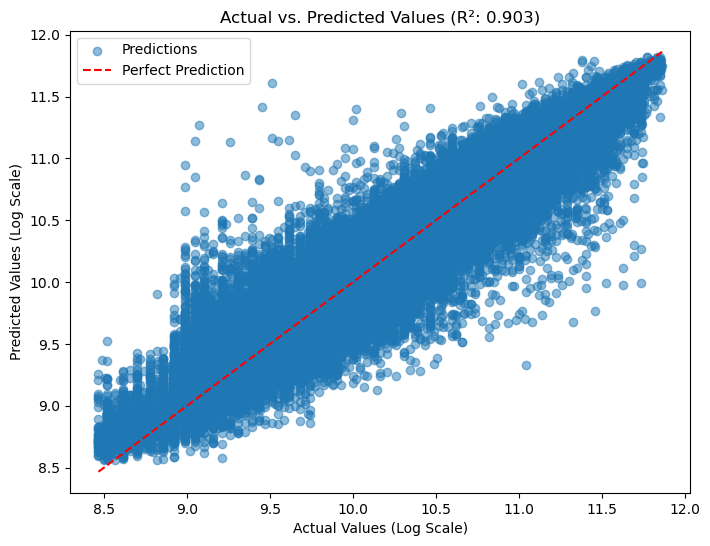

In [15]:
plot_actual_vs_predicted(predictions_df, actual_col="Actual_Log", predicted_col="Predicted_Log")

In [19]:
# Select only the top N important features
top_n = 20  # Change this based on model performance
selected_features = feature_importance.head(top_n)['Feature'].tolist()

# Update X_train and X_test to use only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [22]:
# Train the model again with selected features
best_rf.fit(X_train_selected, y_train)

# Predict using only selected features
preds_log = best_rf.predict(X_test_selected)
preds_expm1 = np.expm1(preds_log)  # Convert back to original scale

In [25]:
# Predict and evaluate
preds1= best_rf.predict(X_test_selected)
train_pred1 = best_rf.predict(X_train_selected)
mae1 = mean_absolute_error(y_test, preds1)
mse1 = mean_squared_error(y_test, preds1)
rmse1 = np.sqrt(mse1)

# Feature Importance
feature_importance1 = pd.DataFrame({'Feature': X_test_selected.columns, 'Importance': best_rf.feature_importances_})
feature_importance1 = feature_importance1.sort_values(by='Importance', ascending=False)

# Save prepared dataset
#prepared_data_path = "/mnt/data/prepared_dataset.csv"
#df.to_csv(prepared_data_path, index=False)

#print(f"Prepared dataset saved to {prepared_data_path}")
#print(f"Best Parameters: {grid_search.best_params_}")
#print(f"Cross-Validation RMSE: {cv_rmse1}")
print(f"MAE: {mae1}")
print(f"MSE: {mse1}")
print(f"RMSE: {rmse1}")
print("Top 10 Important Features:")
print(feature_importance.head(20))

print("RMSE Baseline accuracy:", y_test.std())
print("Train RMSE:", RMSE(y_train, train_pred1))
print("Test RMSE:", RMSE(y_test, preds1))


MAE: 0.1552141301768604
MSE: 0.04666495708030161
RMSE: 0.21602073298714086
Top 10 Important Features:
                      Feature  Importance
15                  Enclosure    0.218366
4                    YearMade    0.120608
10         fiProductClassDesc    0.095516
19                 Hydraulics    0.084821
1                     ModelID    0.076284
8             fiSecondaryDesc    0.074065
29                  sale_year    0.069666
6                 fiModelDesc    0.057253
9                 ProductSize    0.052035
7                 fiBaseModel    0.024376
13           ProductGroupDesc    0.019417
12               ProductGroup    0.019043
0                   MachineID    0.015645
14               Drive_System    0.010721
30                 sale_month    0.009817
31                   sale_day    0.009564
11                      state    0.009458
23                 Track_Type    0.008088
3                auctioneerID    0.005496
34  YearMade_Bucket_1980-2000    0.003401
RMSE Baseline ac

### new data set valid

In [85]:
# Load dataset
file_path = r"C:\Users\eitanb\Documents\GitHub\ML_project\Valid.csv"
df = pd.read_csv(file_path)
df1=df.copy()


In [86]:
# Ensure SalesID exists
if "SalesID" not in df1.columns:
    raise ValueError("SalesID column not found in the dataset!")

# Store SalesID and original index
sales_id_col = df1[['SalesID']].copy()
original_index = df1.index  # Store the original DataFrame index





In [87]:


if 'saledate' in df1.columns:
    df1['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
    df1['sale_year'] = df1['saledate'].dt.year
    df1['sale_month'] = df1['saledate'].dt.month
    df1['sale_day'] = df1['saledate'].dt.day
    df1.drop(columns=['saledate'], inplace=True)


# Drop irrelevant columns
columns_to_drop = ["SalesID", "Unnamed: 0"]  # Drop IDs and redundant columns
df1.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Handle missing values
for col in df1.select_dtypes(include=['number']).columns:
    df1[col].fillna(df1[col].median(), inplace=True)  # Impute numeric values with median

for col in df1.select_dtypes(include=['object']).columns:
    df1[col].fillna(df1[col].mode()[0] if not df1[col].mode().empty else "Unknown", inplace=True)  # Impute categorical with mode or 'Unknown'
# Handle outliers
# Apply log transformation to SalePrice
#df1['SalePrice'] = np.log1p(df1['SalePrice'])

# Cap MachineHoursCurrentMeter at the 99th percentile
if 'MachineHoursCurrentMeter' in df1.columns:
    upper_limit = df1['MachineHoursCurrentMeter'].quantile(0.99)
    df1['MachineHoursCurrentMeter'] = np.where(df1['MachineHoursCurrentMeter'] > upper_limit, upper_limit, df1['MachineHoursCurrentMeter'])

# Fix YearMade errors
# Replace values below 1900 with NaN and impute with median
df1.loc[df1['YearMade'] < 1900, 'YearMade'] = np.nan
df1['YearMade'].fillna(df1['YearMade'].median(), inplace=True)

# Bucketize YearMade
bins = [1900, 1950, 1980, 2000, 2010, 2025]
labels = ['Pre-1950', '1950-1980', '1980-2000', '2000-2010', 'Post-2010']
df1['YearMade_Bucket'] = pd.cut(df1['YearMade'], bins=bins, labels=labels)

# Convert categorical variables to numeric using One-Hot Encoding or Label Encoding
label_encoders = {}
df1 = pd.get_dummies(df1, columns=['YearMade_Bucket'])  # One-Hot Encoding for bucketized YearMade
for col in df1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col])
    label_encoders[col] = le


In [89]:
X_test_selected1=df1[selected_features].copy()

In [95]:
# Ensure predictions align with the original index
predictions = best_rf.predict(X_test_selected1)

# Verify matching row count
if len(predictions) != len(X_test_selected1):
    raise ValueError("Mismatch in row count between processed data and predictions!")

# Reconstruct results DataFrame, ensuring index alignment
results = pd.DataFrame({
    "SalesID": sales_id_col.iloc[:, 0],  # Ensure correct alignment
    "SalePrice": np.expm1(predictions)  # Reverse log transformation
}, index=original_index)

In [96]:
results

,SalesID,SalePrice
0,1222837,34286.944076
1,1222839,66962.303513
2,1222841,33791.351940
3,1222843,45950.876190
4,1222845,34229.151458
...,...,...
11568,6333344,16099.609639
11569,6333345,12516.663540
11570,6333347,11276.537904
11571,6333348,13342.016889


In [97]:

results=results.reset_index(drop=True) 

In [98]:
results

,SalesID,SalePrice
0,1222837,34286.944076
1,1222839,66962.303513
2,1222841,33791.351940
3,1222843,45950.876190
4,1222845,34229.151458
...,...,...
11568,6333344,16099.609639
11569,6333345,12516.663540
11570,6333347,11276.537904
11571,6333348,13342.016889


In [99]:
results.to_csv(r"C:\Users\eitanb\Documents\GitHub\ML_project\V_1_Valiad.csv")